## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import os
#HOME = '/content/drive/My Drive/'
HOME = os.getcwd()
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

#CHECKPOINT_PATH = os.path.join("/content/drive/My Drive/sam-iiif/weights/sam_vit_h_4b8939.pth")
CHECKPOINT_PATH = os.path.join(HOME, 'weights', 'sam_vit_h_4b8939.pth')
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
import json
uploaded = files.upload()
filename = next(iter(uploaded))
data = next(iter(uploaded.values()))
manifest = json.loads(data.decode('utf-8-sig'))

Saving MiradorAnnotations_Enluminures.json to MiradorAnnotations_Enluminures.json


In [4]:
import codecs
import re
from PIL import Image
import urllib.request as urllib2
from io import BytesIO
import base64
import io
from google.colab import output
output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget


def encode_image(url):
  contents = urllib2.urlopen(url).read()
  encoded = str(base64.b64encode(contents), 'utf-8')
  return "data:image/jpg;base64,"+encoded


# Charger l'image

for key, value in manifest.items():
  for key3, value3 in value.items():
    iiif_link = ''.join([re.sub('/canvas', '', str(key3)), '/full/full/0/native.jpg'])
    tags = []

    for element in value3:
      for key4, value4 in element.items():
        if key4 == 'resource':
          for element2 in value4:
            for key2, value2 in element2.items():
              if key2=='chars':
                if '<p>' in value2:
                  pass
                else:
                  tags.append(value2)


print(tags)

image1 = encode_image(iiif_link)
widget = BBoxWidget(
    image=image1,
    classes=tags,
)
widget

['arbre', 'chasse', 'étoffe', 'filet', 'palmier', 'parabole', 'piège', 'rossignol', 'turban', 'vêtement']


BBoxWidget(classes=['arbre', 'chasse', 'étoffe', 'filet', 'palmier', 'parabole', 'piège', 'rossignol', 'turban…

In [5]:
widget.bboxes

[{'x': 2364, 'y': 1924, 'width': 361, 'height': 245, 'label': 'rossignol'},
 {'x': 1871, 'y': 781, 'width': 443, 'height': 190, 'label': 'rossignol'}]

--2024-06-26 09:15:09--  https://gallica.bnf.fr/iiif/ark:/12148/btv1b8419219x/f95/full/full/0/native.jpg
Resolving gallica.bnf.fr (gallica.bnf.fr)... 194.199.8.11
Connecting to gallica.bnf.fr (gallica.bnf.fr)|194.199.8.11|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 2001760 (1.9M) [image/jpeg]
Saving to: ‘native.jpg.1’

native.jpg.1        100%[===================>]   1.91M   977KB/s    in 2.0s    

2024-06-26 09:15:17 (977 KB/s) - ‘native.jpg.1’ saved [2001760/2001760]



SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


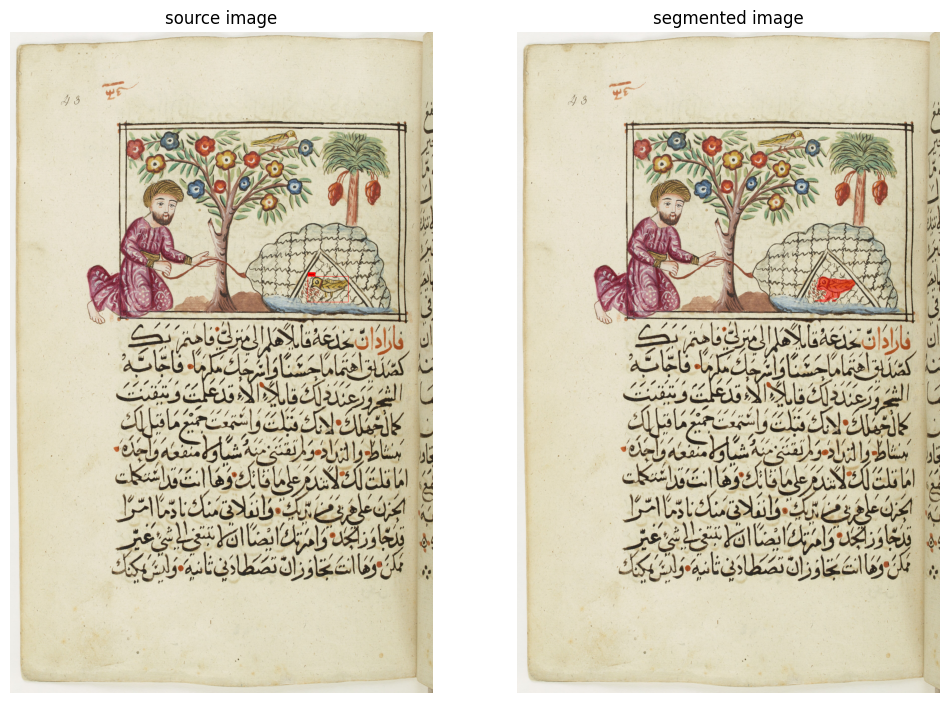

In [7]:
import cv2
import supervision as sv
import numpy as np

box = widget.bboxes[0]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

!wget $iiif_link

image_bgr = cv2.imread(HOME + '/native.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.RED)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [16]:
for e in manifest[key][key3]:
    for i, e2 in enumerate(e['resource']):
        for k, v in e2.items():
            if k == 'chars':
                if widget.bboxes[1]['label'] == v:
                    manifest[key][key3][manifest[key][key3].index(e)]['resource'][i]['zone'] = str(detections.xyxy)

json_name = filename+'_edited.json'
json.dump(manifest, codecs.open(json_name, 'w', encoding='utf-8'),
          indent=4, ensure_ascii=False)